## Current Status:
- Using a train and validation set, I don't seem to be getting better than 68% accuracy for the best performing model (Random Forest with poor performing features (`OnTime`, `DeliverySatisfaction`) removed
- Looked at NaiveBayes, RandomForest, DecisionTrees, XGBoost, LogisticRegression
- Tried PCA on the features without much success, never done that before so possible I am doing that incorrectly, still looking into that
- Feel like I either need to be doing more with feature engineering or that I'm not doing something in my model building, cross-validation or interpretation of the results correctly


- Need to clean this up a bit more, i'll try to get a cleaner version before our meeting Monday

In [2]:
# Add needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

# VIF for multi-collinearity detection
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Models and modeling tools
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm

# Change inline plots default size
plt.rcParams['figure.figsize'] = [12, 8]

In [3]:
# Read in the rawData
columns = ['Happy', 'OnTime', 'OrderCorrect', 'FoundEverything', 'GoodPrice', 'DeliverySatisfaction', 'EasyToUse']
rawData = pd.read_csv('ACME-HappinessSurvey2020.csv', header=0, names=columns)

# Separate data in independent (features) and dependent (target) datasets
features = rawData.copy()
target = features.pop('Happy')

############################################################################################################################### \
############################################################################################################################### \
############################################################################################################################### 

## Exploratory Data Analysis

In [3]:
# Initial descriptive statistics investigation into the dataset
rawData.describe()

,Happy,OnTime,OrderCorrect,FoundEverything,GoodPrice,DeliverySatisfaction,EasyToUse
count,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000
mean,0.547619,4.333333,2.531746,3.309524,3.746032,3.650794,4.253968
std,0.499714,0.800000,1.114892,1.023440,0.875776,1.147641,0.809311
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,4.000000,2.000000,3.000000,3.000000,3.000000,4.000000
50%,1.000000,5.000000,3.000000,3.000000,4.000000,4.000000,4.000000
75%,1.000000,5.000000,3.000000,4.000000,4.000000,4.000000,5.000000
max,1.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [4]:
# Check for missing data
rawData.isna().sum()

Happy                   0
OnTime                  0
OrderCorrect            0
FoundEverything         0
GoodPrice               0
DeliverySatisfaction    0
EasyToUse               0
dtype: int64

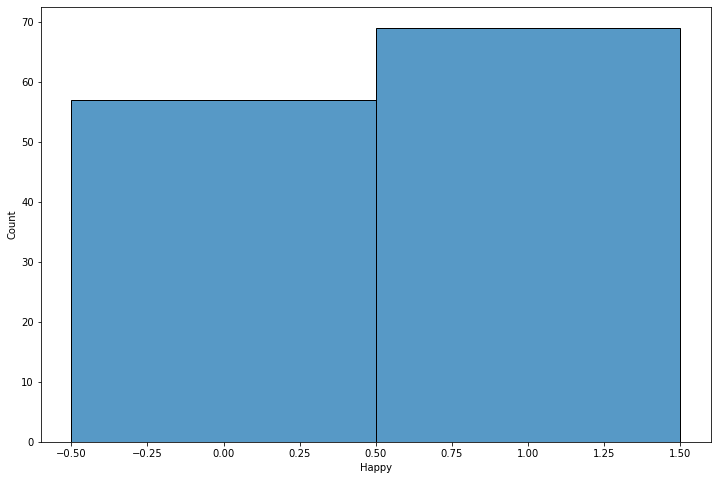

In [5]:
# Plot response variable
fig, axs = plt.subplots()
sns.histplot(data=rawData, x='Happy',discrete=True)
plt.show()

### Initial description: 
- N=126 datapoints, 
- Response Variable (Y) is binary 
- Predictors are all ordinal from 1-5.
- No missing data
- Response variable balanced between 0 and 1 responses

- This is consistent with the data descriptions provided:

```
Data Description:

Y = target attribute (Y) with values indicating 0 (unhappy) and 1 (happy) customers
X1 = my order was delivered on time
X2 = contents of my order was as I expected
X3 = I ordered everything I wanted to order
X4 = I paid a good price for my order
X5 = I am satisfied with my courier
X6 = the app makes ordering easy for me

Attributes X1 to X6 indicate the responses for each question and have values from 1 to 5 where the smaller number indicates less and the higher number indicates more towards the answer.
```

### Initial thoughts: 
- __Balanced Binary response variable__ 
    - Use a classifier (Logistic Regression, SVM, Decision Trees, etc...)
- __Very small dataset__
    - Stick with simple methods (Logistic Regression could be a good fit) 
    - Outliers could have strong influence
- __Predictors are survey data__ 
    - All on same scale so shouldn't need normalization


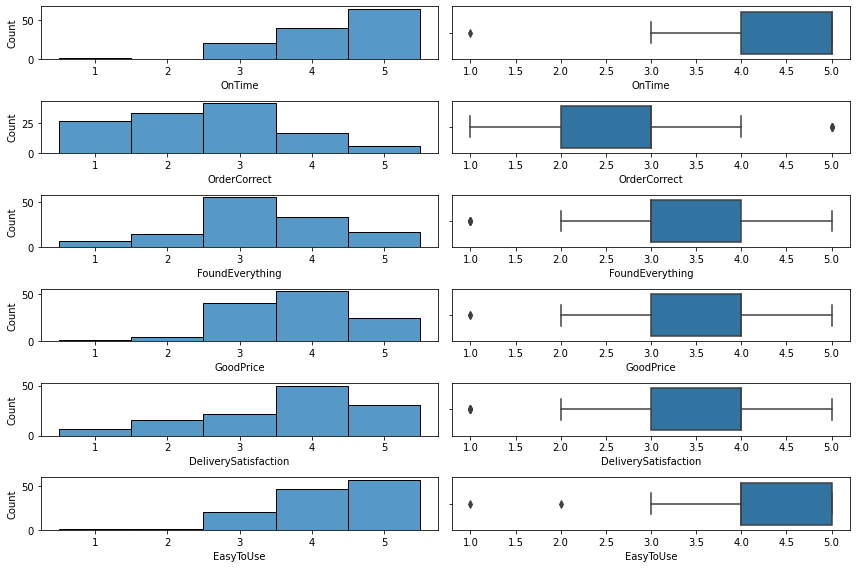

In [6]:
# Plot the feature distributions to look for skewed data/visualize possible outliers
fig, axs = plt.subplots(6,2)
sns.histplot(data=features, x='OnTime', ax=axs[0,0], discrete=True)
sns.histplot(data=features, x='OrderCorrect', ax=axs[1,0], discrete=True)
sns.histplot(data=features, x='FoundEverything', ax=axs[2,0], discrete=True)
sns.histplot(data=features, x='GoodPrice', ax=axs[3,0], discrete=True)
sns.histplot(data=features, x='DeliverySatisfaction', ax=axs[4,0], discrete=True)
sns.histplot(data=features, x='EasyToUse', ax=axs[5,0], discrete=True)

sns.boxplot(data=features, x='OnTime', ax=axs[0,1])
sns.boxplot(data=features, x='OrderCorrect', ax=axs[1,1])
sns.boxplot(data=features, x='FoundEverything', ax=axs[2,1])
sns.boxplot(data=features, x='GoodPrice', ax=axs[3,1])
sns.boxplot(data=features, x='DeliverySatisfaction', ax=axs[4,1])
sns.boxplot(data=features, x='EasyToUse', ax=axs[5,1])
plt.tight_layout()
plt.show()

In [7]:
# Look at skewness in the independent variables
features.skew()

OnTime                 -1.058468
OrderCorrect            0.271000
FoundEverything        -0.199536
GoodPrice              -0.422240
DeliverySatisfaction   -0.699999
EasyToUse              -0.957590
dtype: float64

In [8]:
# Look at the correlations between independent variables
features.corr()

,OnTime,OrderCorrect,FoundEverything,GoodPrice,DeliverySatisfaction,EasyToUse
OnTime,1.000000,0.059797,0.283358,0.087541,0.432772,0.411873
OrderCorrect,0.059797,1.000000,0.184129,0.114838,0.039996,-0.062205
FoundEverything,0.283358,0.184129,1.000000,0.302618,0.358397,0.203750
GoodPrice,0.087541,0.114838,0.302618,1.000000,0.293115,0.215888
DeliverySatisfaction,0.432772,0.039996,0.358397,0.293115,1.000000,0.320195
EasyToUse,0.411873,-0.062205,0.203750,0.215888,0.320195,1.000000


In [9]:
# Generate VIF factors for each feature
tst = ['OnTime', 'OrderCorrect', 'FoundEverything', 'GoodPrice', 'DeliverySatisfaction', 'EasyToUse']

vif_scores = pd.DataFrame() 
vif_scores["Attribute"] = features.columns 
  
# calculating VIF for each feature 
vif_scores["VIF Scores"] = [variance_inflation_factor(features.values, i) for i in range(len(features.columns))] 
  
display(vif_scores)

,Attribute,VIF Scores
0,OnTime,35.247226
1,OrderCorrect,6.184639
2,FoundEverything,14.664274
3,GoodPrice,19.882237
4,DeliverySatisfaction,15.813355
5,EasyToUse,31.895668


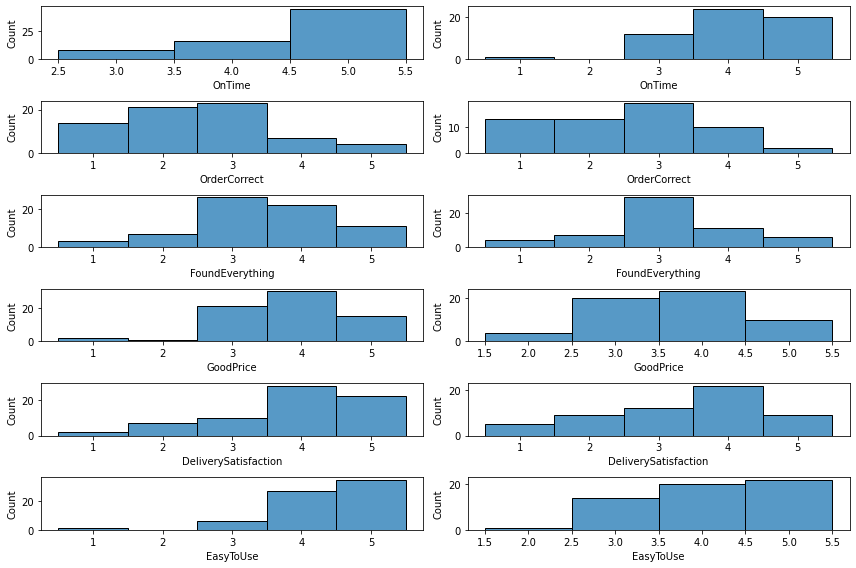

In [10]:
# Look at distributions against happy/unhappy
happy = rawData.loc[rawData.Happy == 1]
unhappy = rawData.loc[rawData.Happy == 0]

fig, axs = plt.subplots(6,2)
sns.histplot(data=happy, x='OnTime', ax=axs[0,0], discrete=True)
sns.histplot(data=happy, x='OrderCorrect', ax=axs[1,0], discrete=True)
sns.histplot(data=happy, x='FoundEverything', ax=axs[2,0], discrete=True)
sns.histplot(data=happy, x='GoodPrice', ax=axs[3,0], discrete=True)
sns.histplot(data=happy, x='DeliverySatisfaction', ax=axs[4,0], discrete=True)
sns.histplot(data=happy, x='EasyToUse', ax=axs[5,0], discrete=True)

sns.histplot(data=unhappy, x='OnTime', ax=axs[0,1], discrete=True)
sns.histplot(data=unhappy, x='OrderCorrect', ax=axs[1,1], discrete=True)
sns.histplot(data=unhappy, x='FoundEverything', ax=axs[2,1], discrete=True)
sns.histplot(data=unhappy, x='GoodPrice', ax=axs[3,1], discrete=True)
sns.histplot(data=unhappy, x='DeliverySatisfaction', ax=axs[4,1], discrete=True)
sns.histplot(data=unhappy, x='EasyToUse', ax=axs[5,1], discrete=True)
plt.tight_layout()
plt.show()

In [11]:
from sklearn.feature_selection import mutual_info_classif

def make_mi_scores(X, y):
    mi_scores = mutual_info_classif(X, y, discrete_features=True)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(features, target)
display (mi_scores)

OnTime                  0.049705
EasyToUse               0.035543
DeliverySatisfaction    0.027627
GoodPrice               0.021880
FoundEverything         0.017432
OrderCorrect            0.009468
Name: MI Scores, dtype: float64

### Discussion on Features

__Shape__
- Most of the data is slightly left skewed
- Overall skewness does not seem like a concern

__Outliers__
- Every feature has potential outliers
- Potential outliers most likely to have an outsized outcome on the model are in the `OnTime` and `EasyToUse` rare low ratings (1/2)
- May want to run model with and without the low ratings in `OnTime` and `EasyToUse` to see how strong an influence they have

__Multicollinearity__
- Direct correlations between features is moderate at worst
- Extremely high VIF scores across all but `OrderCorrect` suggesting strong multicollinearity
- This is not surprising as someone who had a positive experience will tend to fill out more positive scores and those with a negative experience will tend to fill out more negative scores
- Selecting a subset of features will be the best approach to try to address realtionships between features 
- Non-parametric approaches like Decision Tree methods may also be a better approach than logistic regression

__Feature Selections__
- `OnTime` and `EasyToUse` top the MI metric, though all seem low in general, with `OnTime`'s relationship between happiness also apparent graphically
- `OrderCorrect` does not seem to have much predictive power
- `DeliverySatisfaction` and `FoundEverything` and `GoodPrice`'s relationships with happiness are hard to differentiate graphically and are in the middle of the pack relatively for MI scores
- Overall, `OnTime` and `EasyToUse` seem most important to prediction of overall Happiness

__Other Comments__
- `OrderCorrect` is concerning, seems to have little predictive power, but has an average of only 2.5 (low compared to all the other categories).  This would imply that many people are not getting what they expected, yet seems to not be important to their overall happiness, which is counter-intuitive.  I would suggest looking into the source of that data further for possible issues.  If the data is valid, despite not being a current customer concern, seems like something that should be investigated further internally.

############################################################################################################################### \
############################################################################################################################### \
############################################################################################################################### 

## MODELS


<AxesSubplot:ylabel='valAcc'>

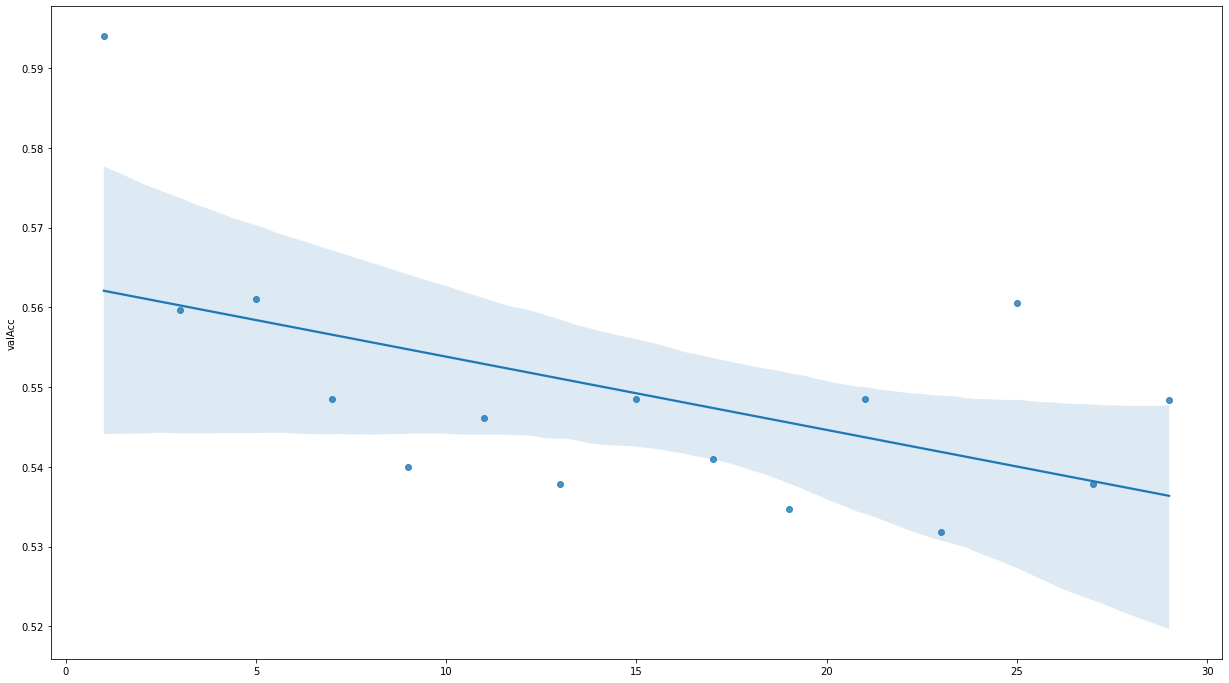

In [138]:
### HELPER FUNCTIONS
def paramSearch(model, param, valRange, dataset):
    valDict = {}
    for val in valRange:
        trainAcc = []
        accuracy = []
        for i in range(0, 100):
            # Split dataset into train/validate datasets
            train, valid = train_test_split(dataset, test_size=randSize, stratify=dataset['Happy'])
            
            # Split off target
            train_y = train.pop('Happy')
            valid_y = valid.pop('Happy')

            # Specify model with parameter value
            args = {param: val}
            clf = model(**args)
            
            # Train model
            clf.fit(train, train_y)

            # Evaluate model
            ypred = clf.predict(valid)
            ypredTrain = clf.predict(train)
            
            # Analyze Performance
            trainAcc.append((ypredTrain - train_y).value_counts()[0]/len(train_y))
            accuracy.append((ypred - valid_y).value_counts()[0]/len(valid_y))
        
        valDict[val] = {'valAcc': np.array(accuracy).mean(), 'trainAcc': np.array(trainAcc).mean()}
    
    return pd.DataFrame(valDict)

results = paramSearch(tree.DecisionTreeClassifier, 'max_depth', np.arange(1,30,2), rawData.copy())

sns.regplot(data=results.transpose(),x=results.transpose().index, y='valAcc')

<AxesSubplot:>

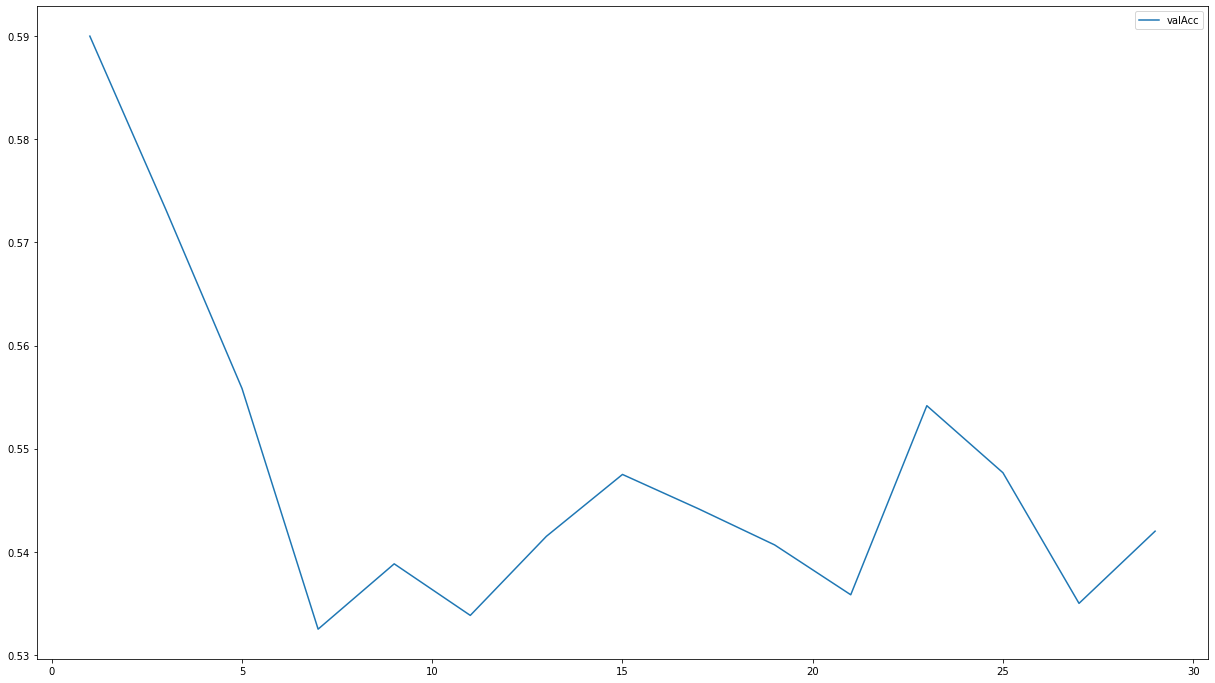

In [136]:
results.transpose().plot(y='valAcc')

### Decision Tree

Correct:  0.746031746031746
Pred Unhappy when Happy:  0.03968253968253968
Pred Happy when Unhappy:  0.21428571428571427


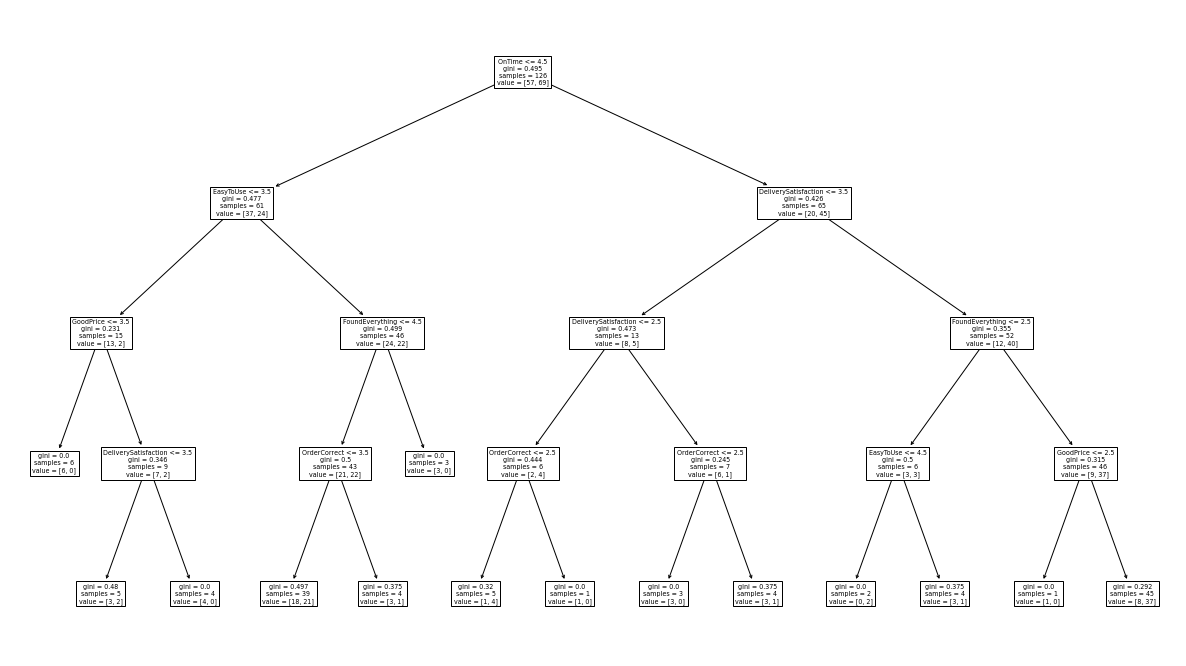

In [71]:
# Decision Tree
plt.rcParams['figure.figsize'] = [21, 12]
decTree = tree.DecisionTreeClassifier(max_depth=4)
decTree = decTree.fit(features, target)

# Assess training set performance
pred = decTree.predict(features)
error = target - pred
print ('Correct: ', error.value_counts()[0]/len(pred))
print ('Pred Unhappy when Happy: ', error.value_counts()[1]/len(pred))
print ('Pred Happy when Unhappy: ', error.value_counts()[-1]/len(pred))

# Visualize Tree
tmp = tree.plot_tree(decTree, feature_names=features.columns.values)

In [133]:
# Decision Tree with Validation Set
accuracy = []
for i in range(0, 100):
    train, valid = train_test_split(rawData, test_size=0.20, stratify=rawData['Happy'])
    train_y = train.pop('Happy')
    valid_y = valid.pop('Happy')
    
    decTree = tree.DecisionTreeClassifier(max_depth=1, splitter='best', max_features=4)
    decTree = decTree.fit(train, train_y)
    pred = decTree.predict(valid)
    error = valid_y - pred
    
    correct = error.value_counts()[0]/len(pred)
    if (1 in error.value_counts()):
        errUnhappy = error.value_counts()[1]/len(pred)
    else:
        errUnhappy = 0.0
    if (-1 in error.value_counts()):
        errHappy = error.value_counts()[-1]/len(pred)
    else:
        errHappy = 0.0
    
    accuracy.append({'Correct': correct, 'errUnhappy': errUnhappy, 'errHappy': errHappy})
    
accDataset = pd.DataFrame(accuracy)
print ('Correct: ', accDataset.Correct.mean())
print ('Pred Unhappy when Happy: ', accDataset.errUnhappy.mean())
print ('Pred Happy when Unhappy: ', accDataset.errHappy.mean())

Correct:  0.6096153846153848
Pred Unhappy when Happy:  0.16730769230769216
Pred Happy when Unhappy:  0.22307692307692306


### Multiple Regression
Don't think this will work, but curious to see what if anything is significant

In [152]:
output = []
for column in features[['GoodPrice', 'OrderCorrect', 'FoundEverything', 'DeliverySatisfaction']]:
    xTrain = pd.DataFrame(features[['OnTime', column]])
    #xTrain = features[column]
    xTrain = sm.add_constant(xTrain)
    #display (xTrain)
    logModel = sm.OLS(target, xTrain)
    results = logModel.fit()
    output.append([results.summary2])#[results.pvalues.index[1], results.pvalues.values[1], results.rsquared])
    print (results.summary2())
#display (pd.DataFrame(output))

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.065   
Dependent Variable: Happy            AIC:                177.2325
Date:               2022-06-16 18:23 BIC:                185.7414
No. Observations:   126              Log-Likelihood:     -85.616 
Df Model:           2                F-statistic:        5.355   
Df Residuals:       123              Prob (F-statistic): 0.00589 
R-squared:          0.080            Scale:              0.23345 
------------------------------------------------------------------
                Coef.   Std.Err.     t     P>|t|    [0.025  0.975]
------------------------------------------------------------------
const          -0.2871    0.2896  -0.9914  0.3234  -0.8604  0.2861
OnTime          0.1728    0.0542   3.1866  0.0018   0.0655  0.2801
GoodPrice       0.0229    0.0495   0.4630  0.6442  -0.0751  0.1210
-----------------------------------------------------------------
Omnibus:             

### Logistic Regression

In [4]:
# Single feature logistic regression model
for col in features.columns:
    clf = LogisticRegression().fit(features[[col]], target)
    predict = clf.predict(features[[col]])
    #clf.predict_proba(features[:2, :])
    res = (predict - target)
    print (col, res.value_counts()[0]/126)

OnTime 0.6507936507936508
OrderCorrect 0.5476190476190477
FoundEverything 0.5555555555555556
GoodPrice 0.5555555555555556
DeliverySatisfaction 0.6031746031746031
EasyToUse 0.6111111111111112


### More Decision Trees

In [153]:
from sklearn import tree

clf = tree.DecisionTreeClassifier(max_depth=6)
clf = clf.fit(features, target)

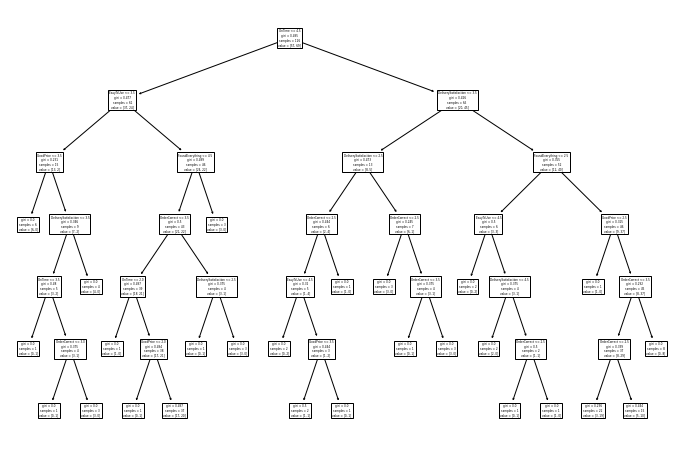

In [154]:
tmp = tree.plot_tree(clf, feature_names=features.columns.values)

### Monte Carlo Cross Validation

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
    
accuracy = []
logAccuracy = []
svmAccuracy = []
ensAccuracy = []
for i in range(0, 10):
    train, valid = train_test_split(rawData, test_size=0.20, stratify=rawData['Happy'])
    train_y = train.pop('Happy')
    valid_y = valid.pop('Happy')
    
    #train['Sum'] = train.sum(axis=1)
    #valid['Sum'] = valid.sum(axis=1)
    
    # Decision Tree
    clf = tree.DecisionTreeClassifier(max_depth=5)
    clf = clf.fit(train, train_y)
    ypred = clf.predict(valid)

    # Linear SVM
    clf = SVC(kernel='linear',gamma=0.03)
    clf.fit(train, train_y)
    svmpred = clf.predict(valid)
    
    # Logistic Regression
    train = train[['OnTime']]
    valid = valid[['OnTime']]
    train = sm.add_constant(train)
    valid = sm.add_constant(valid)
    logModel = sm.Logit(train_y, train)
    results = logModel.fit()
    ylogpred = results.predict(valid)
    
    ensem = (svmpred + ylogpred.round(0) + ypred)/3.0
    
    accuracy.append((ypred - valid_y).value_counts()[0]/len(valid_y))
    logAccuracy.append((ylogpred.round(0) - valid_y).value_counts()[0.0]/len(valid_y))
    svmAccuracy.append((svmpred - valid_y).value_counts()[0.0]/len(valid_y))
    ensAccuracy.append((ensem.round(0) - valid_y).value_counts()[0.0]/len(valid_y))

    
print (np.array(accuracy).mean())
print (np.array(logAccuracy).mean())
print (np.array(svmAccuracy).mean())
print (np.array(ensAccuracy).mean())

#### Looking at whether the sum of the features is a useful feature

In [260]:
train.sum(axis=1)

68     26
93     26
86     24
63     27
118    22
       ..
123    24
34     14
113    23
43     20
49     20
Length: 100, dtype: int64

In [262]:
tst = train.copy()

In [264]:
tst['Sum'] = tst.sum(axis=1) 

In [269]:
train_y#,tst['Sum']

68     1
93     1
86     1
63     0
118    1
      ..
123    1
34     1
113    0
43     0
49     1
Name: Happy, Length: 100, dtype: int64

In [419]:
accuracy

[0.4230769230769231,
 0.5,
 0.5384615384615384,
 0.46153846153846156,
 0.6538461538461539,
 0.5384615384615384,
 0.5769230769230769,
 0.46153846153846156,
 0.5,
 0.5384615384615384]

In [420]:
logAccuracy

[0.6153846153846154,
 0.5769230769230769,
 0.6538461538461539,
 0.6538461538461539,
 0.6538461538461539,
 0.7307692307692307,
 0.5384615384615384,
 0.5769230769230769,
 0.5384615384615384,
 0.6923076923076923]

In [483]:
svmpred + ylogpred

114    1.680716
23     0.680716
86     1.680716
53     1.680716
119    1.680716
88     1.680716
118    0.491038
4      1.680716
105    1.680716
113    1.680716
70     0.491038
13     0.491038
51     1.680716
9      1.491038
8      1.491038
96     0.491038
66     0.303906
38     1.680716
22     1.491038
117    1.680716
49     1.680716
44     0.303906
111    1.680716
34     0.491038
31     1.491038
98     0.491038
dtype: float64

In [482]:
# Trying a mixture of the models
for col in features.columns:
    logAccuracy = []
    for i in range(0, 10):
        train, valid = train_test_split(rawData, test_size=0.20, stratify=rawData['Happy'])
        train_y = train.pop('Happy')
        valid_y = valid.pop('Happy')

        train = train[[col]]
        valid = valid[[col]]
        train = sm.add_constant(train)
        valid = sm.add_constant(valid)
        logModel = sm.Logit(train_y, train)
        results = logModel.fit()
        ylogpred = results.predict(valid)

        ensem = (svmpred + ylogpred.round(0) + ypred)/3.0

        logAccuracy.append((ylogpred.round(0) - valid_y).value_counts()[0.0]/len(valid_y))


    print (np.array(logAccuracy).mean())

114    1.0
23     1.0
86     1.0
53     1.0
119    1.0
88     1.0
118    0.0
4      1.0
105    1.0
113    1.0
70     0.0
13     0.0
51     1.0
9      0.0
8      0.0
96     0.0
66     0.0
38     1.0
22     0.0
117    1.0
49     1.0
44     0.0
111    1.0
34     0.0
31     0.0
98     0.0
dtype: float64

In [500]:
rawData.value_counts()

Happy  OnTime  OrderCorrect  FoundEverything  GoodPrice  DeliverySatisfaction  EasyToUse
1      5       1             3                3          4                     4            3
               5             5                5          5                     5            2
               3             3                4          4                     5            2
0      5       4             3                3          3                     5            2
1      4       1             3                4          4                     4            2
                                                                                           ..
0      4       5             5                5          1                     3            1
               4             4                4          3                     4            1
                                                         1                     3            1
                                              2          5       

## Random Forest

In [79]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# Loop through and try with various features removed
remove = ['OnTime','OrderCorrect','FoundEverything','GoodPrice','DeliverySatisfaction','EasyToUse']
for cat in remove:
    remove2 = ['OnTime','OrderCorrect','FoundEverything','GoodPrice','DeliverySatisfaction','EasyToUse']
    for cat2 in remove2:
        if (cat2 != cat):
            accuracy = []
            for i in range(0, 100):
                train, valid = train_test_split(rawData, test_size=0.20, stratify=rawData['Happy'])
                train_y = train.pop('Happy')
                valid_y = valid.pop('Happy')

                train.pop(cat)
                valid.pop(cat)
                
                train.pop(cat2)
                valid.pop(cat2)

                #train['Sum'] = train.sum(axis=1)
                #valid['Sum'] = valid.sum(axis=1)

                # Random forest model
                clf = RandomForestClassifier()
                clf = clf.fit(train, train_y)
                ypred = clf.predict(valid)

                accuracy.append((ypred - valid_y).value_counts()[0]/len(valid_y))

            print (cat, cat2, np.array(accuracy).mean())

OnTime OrderCorrect 0.5046153846153847
OnTime FoundEverything 0.5461538461538462
OnTime GoodPrice 0.48230769230769227
OnTime DeliverySatisfaction 0.5234615384615384
OnTime EasyToUse 0.5726923076923077
OrderCorrect OnTime 0.5015384615384616
OrderCorrect FoundEverything 0.5984615384615384
OrderCorrect GoodPrice 0.6426923076923078
OrderCorrect DeliverySatisfaction 0.6788461538461539
OrderCorrect EasyToUse 0.6046153846153846
FoundEverything OnTime 0.541923076923077
FoundEverything OrderCorrect 0.5823076923076923
FoundEverything GoodPrice 0.6215384615384615
FoundEverything DeliverySatisfaction 0.5746153846153846
FoundEverything EasyToUse 0.6030769230769232
GoodPrice OnTime 0.4896153846153846
GoodPrice OrderCorrect 0.6438461538461538
GoodPrice FoundEverything 0.626923076923077
GoodPrice DeliverySatisfaction 0.606153846153846
GoodPrice EasyToUse 0.5961538461538461
DeliverySatisfaction OnTime 0.5265384615384616
DeliverySatisfaction OrderCorrect 0.6865384615384614
DeliverySatisfaction FoundEver

In [150]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import random

trainAccuracy = []
accuracy = []
for i in range(0, 100):
    randSize = (random.random()*0.9)/2.0 + 0.05
    train, valid = train_test_split(rawData, test_size=randSize, stratify=rawData['Happy'])
    train_y = train.pop('Happy')
    valid_y = valid.pop('Happy')

    #train['Sum'] = train.sum(axis=1)
    #valid['Sum'] = valid.sum(axis=1)

    clf = RandomForestClassifier(n_estimators=100, max_depth=11, min_samples_leaf=1, min_samples_split=2)
    clf = clf.fit(train, train_y)
    ypred = clf.predict(valid)
    ypredTrain = clf.predict(train)

    trainAccuracy.append((ypredTrain - train_y).value_counts()[0]/len(train_y))        
    accuracy.append((ypred - valid_y).value_counts()[0]/len(valid_y))

print (np.array(accuracy).mean(), np.array(trainAccuracy).mean())

0.5819270957194472 0.9554916359783463


### Naive Bayes
- Gaussian may not be a good assumption here

In [151]:
from sklearn.naive_bayes import GaussianNB

trainAccuracy = []
accuracy = []
for i in range(0, 100):
    randSize = (random.random()*0.9)/2.0 + 0.05
    train, valid = train_test_split(rawData, test_size=randSize, stratify=rawData['Happy'])
    train_y = train.pop('Happy')
    valid_y = valid.pop('Happy')

    #train['Sum'] = train.sum(axis=1)
    #valid['Sum'] = valid.sum(axis=1)

    clf = GaussianNB()
    clf = clf.fit(train, train_y)
    ypred = clf.predict(valid)
    ypredTrain = clf.predict(train)

    trainAccuracy.append((ypredTrain - train_y).value_counts()[0]/len(train_y))        
    accuracy.append((ypred - valid_y).value_counts()[0]/len(valid_y))

print (np.array(accuracy).mean(), np.array(trainAccuracy).mean())

0.5576891253608917 0.6041051323124216


### More Random Forest with Monte Carlo cross validation, removing a few features

In [152]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import random

remove = ['OrderCorrect','GoodPrice','DeliverySatisfaction']
for cat in remove:
    trainAccuracy = []
    accuracy = []
    for i in range(0, 100):
        randSize = (random.random()*0.9)/2.0 + 0.05
        train, valid = train_test_split(rawData, test_size=randSize, stratify=rawData['Happy'])
        train_y = train.pop('Happy')
        valid_y = valid.pop('Happy')

        train.pop(cat)
        valid.pop(cat)

        #train['Sum'] = train.sum(axis=1)
        #valid['Sum'] = valid.sum(axis=1)

        clf = RandomForestClassifier(n_estimators=100, max_depth=11, min_samples_leaf=1, min_samples_split=2)
        clf = clf.fit(train, train_y)
        ypred = clf.predict(valid)
        ypredTrain = clf.predict(train)
                
        trainAccuracy.append((ypredTrain - train_y).value_counts()[0]/len(train_y))        
        accuracy.append((ypred - valid_y).value_counts()[0]/len(valid_y))

    print (cat, np.array(accuracy).mean(), np.array(trainAccuracy).mean())

OrderCorrect 0.5574475228350022 0.5979904595250453
GoodPrice 0.5478200534238187 0.5998107703978792
DeliverySatisfaction 0.555566423481298 0.6077868024424213


In [153]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import random


remove = ['OrderCorrect','GoodPrice','DeliverySatisfaction']
for i in range(0, 3):
    cat = remove[i]
    for j in range(i+1, 3):
        cat2 = remove[j]
        trainAccuracy = []
        accuracy = []
        for i in range(0, 100):
            randSize = (random.random()*0.9)/2.0 + 0.05
            train, valid = train_test_split(rawData, test_size=randSize, stratify=rawData['Happy'])
            train_y = train.pop('Happy')
            valid_y = valid.pop('Happy')

            train.pop(cat)
            valid.pop(cat)

            train.pop(cat2)
            valid.pop(cat2)

            #train['Sum'] = train.sum(axis=1)
            #valid['Sum'] = valid.sum(axis=1)

            clf = RandomForestClassifier(n_estimators=100, max_depth=11, min_samples_leaf=1, min_samples_split=2)
            clf = clf.fit(train, train_y)
            ypred = clf.predict(valid)
            ypred = clf.predict(valid)
            ypredTrain = clf.predict(train)
            trainAccuracy.append((ypredTrain - train_y).value_counts()[0]/len(train_y))
            accuracy.append((ypred - valid_y).value_counts()[0]/len(valid_y))

        print (cat, cat2, np.array(accuracy).mean(), np.array(trainAccuracy).mean())

OrderCorrect GoodPrice 0.5595809040289486 0.5921782080872452
OrderCorrect DeliverySatisfaction 0.5315328536883868 0.6023436887932339
GoodPrice DeliverySatisfaction 0.5425059835813566 0.6012567756185043


In [131]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

remove = ['OnTime','OrderCorrect','FoundEverything','GoodPrice','DeliverySatisfaction','EasyToUse']
for i in range(0, 6):
    cat = remove[i]
    for j in range(i+1, 6):
        cat2 = remove[j]
        for k in range(j+1, 6):
            cat3 = remove[k]
            trainAccuracy = []
            accuracy = []
            for i in range(0, 50):
                train, valid = train_test_split(rawData, test_size=0.20, stratify=rawData['Happy'])
                train_y = train.pop('Happy')
                valid_y = valid.pop('Happy')

                train.pop(cat)
                valid.pop(cat)

                train.pop(cat2)
                valid.pop(cat2)

                train.pop(cat3)
                valid.pop(cat3)

                #train['Sum'] = train.sum(axis=1)
                #valid['Sum'] = valid.sum(axis=1)

                clf = RandomForestClassifier(n_estimators=200, max_depth=9)
                clf = clf.fit(train, train_y)
                ypred = clf.predict(valid)
                ypred = clf.predict(valid)
                ypredTrain = clf.predict(train)
                trainAccuracy.append((ypredTrain - train_y).value_counts()[0]/len(train_y))
                accuracy.append((ypred - valid_y).value_counts()[0]/len(valid_y))

            print (cat, cat2, cat3, np.array(accuracy).mean(), np.array(trainAccuracy).mean())

OnTime OrderCorrect FoundEverything 0.5130769230769231 0.7354
OnTime OrderCorrect GoodPrice 0.5038461538461538 0.7452
OnTime OrderCorrect DeliverySatisfaction 0.5769230769230769 0.7526
OnTime OrderCorrect EasyToUse 0.5584615384615383 0.7777999999999998
OnTime FoundEverything GoodPrice 0.5776923076923077 0.7774
OnTime FoundEverything DeliverySatisfaction 0.4846153846153845 0.7380000000000001
OnTime FoundEverything EasyToUse 0.5984615384615385 0.8118000000000001
OnTime GoodPrice DeliverySatisfaction 0.48615384615384616 0.7583999999999999
OnTime GoodPrice EasyToUse 0.5438461538461539 0.7928000000000001
OnTime DeliverySatisfaction EasyToUse 0.48923076923076925 0.7736
OrderCorrect FoundEverything GoodPrice 0.63 0.78
OrderCorrect FoundEverything DeliverySatisfaction 0.6292307692307691 0.7464000000000002
OrderCorrect FoundEverything EasyToUse 0.5984615384615385 0.7913999999999999
OrderCorrect GoodPrice DeliverySatisfaction 0.6823076923076923 0.8062
OrderCorrect GoodPrice EasyToUse 0.616923076

In [87]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

remove = ['OnTime','OrderCorrect','FoundEverything','GoodPrice','DeliverySatisfaction','EasyToUse']
for cat in remove:
    remove2 = ['OnTime','OrderCorrect','FoundEverything','GoodPrice','DeliverySatisfaction','EasyToUse']
    for cat2 in remove2:
        if (cat2 != cat):
            remove3 = ['OnTime','OrderCorrect','FoundEverything','GoodPrice','DeliverySatisfaction','EasyToUse']
            for cat3 in remove3:
                if (cat3 != cat2):
                    if (cat3 != cat):
                        trainAccuracy = []
                        accuracy = []
                        for i in range(0, 50):
                            train, valid = train_test_split(rawData, test_size=0.20, stratify=rawData['Happy'])
                            train_y = train.pop('Happy')
                            valid_y = valid.pop('Happy')

                            train.pop(cat)
                            valid.pop(cat)

                            train.pop(cat2)
                            valid.pop(cat2)

                            #train['Sum'] = train.sum(axis=1)
                            #valid['Sum'] = valid.sum(axis=1)

                            clf = RandomForestClassifier(n_estimators=20, max_depth=7)
                            clf = clf.fit(train, train_y)
                            ypred = clf.predict(valid)
                            ypredTrain = clf.predict(train)

                            trainAccuracy.append((ypredTrain - train_y).value_counts()[0]/len(train_y))
                            accuracy.append((ypred - valid_y).value_counts()[0]/len(valid_y))

                        print (cat, cat2, cat3, np.array(accuracy).mean(), np.array(trainAccuracy).mean())

OnTime OrderCorrect 0.5215384615384615 0.8316
OnTime FoundEverything 0.5630769230769231 0.8522
OnTime GoodPrice 0.5123076923076924 0.8484
OnTime DeliverySatisfaction 0.5261538461538462 0.8534
OnTime EasyToUse 0.6069230769230769 0.8704000000000001
OrderCorrect OnTime 0.5061538461538462 0.8345999999999999
OrderCorrect FoundEverything 0.5838461538461538 0.8088000000000001
OrderCorrect GoodPrice 0.6507692307692308 0.8452
OrderCorrect DeliverySatisfaction 0.6753846153846155 0.8748
OrderCorrect EasyToUse 0.6076923076923076 0.8573999999999999


KeyboardInterrupt: 

### Other scratch work
- XGBoost, PCA on the features first

In [ ]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

print("Number of mislabeled points out of a total %d points : %d"
       % (X_test.shape[0], (y_test != y_pred).sum()))

In [14]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [70]:
from sklearn.ensemble import RandomForestClassifier
import random

trainAccuracy = []
accuracy = []

remove = ['PC0','PC1','PC2','PC3','PC4','PC5']
for i in range(0, 6):
    cat = remove[i]
    for j in range(i+1, 6):
        cat2 = remove[j]
        trainAccuracy = []
        accuracy = []
        for i in range(0, 100):
            train, valid = train_test_split(X_pca, test_size=randSize, stratify=rawData['Happy'])
            train_y = train.pop('Happy')
            valid_y = valid.pop('Happy')

            train.pop(cat)
            valid.pop(cat)

            train.pop(cat2)
            valid.pop(cat2)

            #train['Sum'] = train.sum(axis=1)
            #valid['Sum'] = valid.sum(axis=1)

            #clf = XGBClassifier(n_estimators=5000, learning_rate=0.001, eval_metric='error', use_label_encoder=False)
            clf = RandomForestClassifier(n_estimators=200, max_depth=9)
            #clf = clf.fit(train, train_y, early_stopping_rounds=10, eval_set=[(valid, valid_y)], verbose=False)
            clf = clf.fit(train, train_y)
            ypred = clf.predict(valid)
            ypred = clf.predict(valid)
            ypredTrain = clf.predict(train)
            trainAccuracy.append((ypredTrain - train_y).value_counts()[0]/len(train_y))
            accuracy.append((ypred - valid_y).value_counts()[0]/len(valid_y))

        print (cat, cat2, np.array(accuracy).mean(), np.array(trainAccuracy).mean())

PC0 PC1 0.566 0.9622727272727272
PC0 PC2 0.5623333333333334 0.9639393939393941
PC0 PC3 0.5421666666666666 0.9654545454545455
PC0 PC4 0.48316666666666674 0.9665151515151514
PC0 PC5 0.5248333333333333 0.9654545454545453
PC1 PC2 0.5829999999999999 0.9684848484848484
PC1 PC3 0.5848333333333333 0.9656060606060605
PC1 PC4 0.5471666666666666 0.9622727272727272
PC1 PC5 0.5743333333333333 0.966060606060606
PC2 PC3 0.5818333333333334 0.9645454545454545
PC2 PC4 0.5191666666666667 0.9653030303030302
PC2 PC5 0.5716666666666667 0.9642424242424242
PC3 PC4 0.5249999999999999 0.9653030303030303
PC3 PC5 0.5695 0.9665151515151515
PC4 PC5 0.539 0.9672727272727273


In [45]:
from sklearn.decomposition import PCA

In [59]:
tst = rawData.copy()
tst.pop('Happy')
pca = PCA()
X_pca = pca.fit_transform(tst)

In [60]:
X_pca = pd.DataFrame(X_pca, columns=['PC0','PC1','PC2','PC3','PC4','PC5'])

In [64]:
X_pca = X_pca.join(rawData['Happy'])
X_pca

,PC0,PC1,PC2,PC3,PC4,PC5,Happy
0,1.576026,1.048242,-0.888826,-0.444176,-0.359581,0.497687,0
1,0.427242,-0.140749,-0.923574,-1.766187,1.113533,-0.091899,0
2,0.293515,0.284936,0.694117,0.862937,-0.949145,0.038676,1
3,0.092171,1.206082,1.000899,0.820391,-1.039162,0.121869,0
4,0.092171,1.206082,1.000899,0.820391,-1.039162,0.121869,0
...,...,...,...,...,...,...,...
121,0.081277,-0.429089,0.144870,-0.310508,0.785325,-1.287254,1
122,0.845978,-0.323250,-0.484885,0.448330,-1.628718,-0.510080,1
123,-0.674262,0.070011,0.651274,-0.122201,-0.773069,-0.079130,1
124,-0.347115,0.189672,0.345818,-0.489468,-0.460586,0.664390,0


In [52]:
loadings = pd.DataFrame(
    pca.components_.T,  # transpose the matrix of loadings
      # so the columns are the principal components
    index=tst.columns,  # and the rows are the original features
)
loadings

,0,1,2,3,4,5
OnTime,-0.327148,-0.119661,0.305456,0.367267,-0.312482,-0.743520
OrderCorrect,-0.201344,0.921146,0.306782,-0.042546,-0.090016,0.083193
FoundEverything,-0.495695,0.143426,-0.649090,0.510136,0.208766,0.092606
GoodPrice,-0.308330,0.049018,-0.457531,-0.721146,-0.296756,-0.291685
DeliverySatisfaction,-0.659448,-0.263943,0.414688,-0.263992,0.472833,0.173878
EasyToUse,-0.277097,-0.211023,0.099811,0.115427,-0.734189,0.562466


In [53]:
plot_variance(pca)

NameError: name 'plot_variance' is not defined

In [55]:
mi_scores = make_mi_scores(X_pca, rawData['Happy'])
mi_scores

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, U

5    0.599131
0    0.599131
2    0.599131
3    0.599131
4    0.599131
1    0.599131
Name: MI Scores, dtype: float64

In [56]:
def make_mi_scores(X, y):
    mi_scores = mutual_info_classif(X, y, discrete_features=True)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X_pca, rawData['Happy'])
display (mi_scores)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, U

5    0.599131
0    0.599131
2    0.599131
3    0.599131
4    0.599131
1    0.599131
Name: MI Scores, dtype: float64

In [80]:
tst = np.arange(3,20,2)

In [82]:
for val in tst:
    print (val)

3
5
7
9
11
13
15
17
19
